In [1]:
import numpy as np
import pandas as pd
from os.path import join
from matplotlib import pyplot as plt
%matplotlib inline


base_dir = '/var/www/DeTangle/DeTangle/netAnalysis/'
sample_chip_file = 'data/DREAM5/Network1/net1_chip_features.tsv'


expr_file = 'data/Roots_li/102715_ave.FPKM.pro.csv'

#-------------------------

# from research gates
# true_file = 'data/Roots_li/finding_missing_predicted.csv'

# from paper figure (predicted)
# paper_figure_table_predicted = 'data/Roots_li/paper_figure_table_cytoscape_predicted.csv'
# final_paper_figure_table_predicted = 'data/Roots_li/processed/paper_figure_table_predicted.csv'

# from paper figure (before) --> original
paper_figure_table_original = 'data/Roots_li/paper_figure_table_original_cytoscape.csv'
final_paper_figure_table_original = 'data/Roots_li/processed/paper_figure_table_original.csv'
final_PK_file = 'data/Roots_li/processed/PK_file.csv'

true_file = final_paper_figure_table_original

#---------------------------------------

gene_names_map = 'data/Roots_li/gene_aliases_20130831.txt'  # downloaded
manual_SL_map = 'data/Roots_li/mapping_SL.csv'              # By Dr. Song Li

# output
final_expr_file = 'data/Roots_li/processed/102715_ave.FPKM.pro.tsv'
final_true_file = 'data/Roots_li/processed/true_edge.txt'
final_true_file_all = 'data/Roots_li/processed/true_edge_all.txt' # including missing
final_tf_file = 'data/Roots_li/processed/root_transcription_factors.tsv'
final_chip_file = 'data/Roots_li/processed/root_chip_features.tsv'

final_mapping = 'data/Roots_li/processed/mapping.csv'
final_gene_ids = 'data/Roots_li/processed/root_gene_ids.tsv'


# Cystoscape out to edges

In [2]:
cytoscape_nt = pd.read_csv(paper_figure_table_original)
network = pd.DataFrame(columns=['From', 'To'])

for i,val in enumerate(cytoscape_nt.name):
    temp = val.split(' ')
    network.loc[i] = [temp[0], temp[-1]]

network['edge_type'] = cytoscape_nt['edge_type'].fillna(1)
network.to_csv(final_paper_figure_table_original, header=False, index=False, sep='\t')

network['Predicted'] = cytoscape_nt['Predicted'].fillna(0)
priorKnowledge = network.query('Predicted==0').drop('Predicted', axis=1)
priorKnowledge.to_csv(final_PK_file, header=False, index=False, sep='\t')

priorKnowledge
network

From        To  edge_type  Predicted
0        MGP       SHR        1.0        0.0
1        MGP       JKD        1.0        1.0
2        MGP       MGP       -1.0        0.0
3        MGP      WOX5        1.0        1.0
4        ACR      WOX5       -1.0        0.0
5        ACR       PHB       -1.0        1.0
6        JKD       SHR        1.0        0.0
7        JKD       SCR        1.0        0.0
8        JKD       MGP        1.0        0.0
9        JKD       JKD        1.0        0.0
10       PHB       JKD       -1.0        0.0
11       PHB       PHB        1.0        1.0
12       PHB      WOX5       -1.0        0.0
13      IAA5      WOX5       -1.0        0.0
14      IAA5       PHB        1.0        1.0
15       CLE      WOX5       -1.0        0.0
16       CLE       PHB       -1.0        1.0
17       CLE       CLE        1.0        1.0
18       SHR       SCR        1.0        0.0
19       SHR       SHR        1.0        1.0
20       SHR       PHB        1.0        1.0
21  miRNA165       SHR        1.0        0.0
22  miRNA165  miRNA165        1.0        1.0
23  miRNA165       PHB       -1.0        0.0
24     Auxin      IAA5       -1.0        0.0
25     Auxin       PHB       -1.0        1.0
26      WOX5      WOX5        1.0        0.0
27      WOX5      IAA5        1.0        1.0
28      WOX5       PHB        1.0        1.0
29       SCR       SCR        1.0        0.0
30       SCR  miRNA165        1.0        0.0
31       SCR       JKD        1.0        0.0

In [3]:
mapping = pd.read_csv(gene_names_map, sep='\t')
mapping.fillna('', inplace=True)
# m[m.full_name.str.upper().str.contains('AUXIN')]
mapping.head(2)

locus_name    symbol full_name
0   18S RRNA  18S RRNA          
1   25S RRNA  25S RRNA

In [4]:
true = pd.read_csv(true_file, header=None, sep='\t')
all_genes = np.union1d(true[0].unique(), true[1].unique())
# all_genes = np.union1d(all_genes,  ['ARF', 'PLT']) #######################------------------------>>

print(all_genes.shape)
all_genes

(11,)


array(['ACR', 'Auxin', 'CLE', 'IAA5', 'JKD', 'MGP', 'PHB', 'SCR', 'SHR',
       'WOX5', 'miRNA165'], dtype=object)

In [5]:
cols = ['Original_Gene']
cols.extend(mapping.columns)
found = pd.DataFrame(columns=cols)

index = 0
for gene in all_genes:
    values = mapping[mapping.symbol.str.contains(gene)]
    if values.shape[0]>=1:
        for i in values.index:
            v = values.loc[i]
            found.loc[index] = [gene, v.locus_name, v.symbol, v.full_name]
            index +=1
    else:
        found.loc[index] = (gene, '', '', '')
        index +=1

found.to_csv(final_mapping, index=False)
found.head()

Original_Gene locus_name symbol              full_name
0           ACR  AT1G12420   ACR8    ACT domain repeat 8
1           ACR  AT1G16880  ACR11  ACT domain repeats 11
2           ACR  AT1G69040   ACR4    ACT domain repeat 4
3           ACR  AT1G76990   ACR3    ACT domain repeat 3
4           ACR  AT2G03730   ACR5    ACT domain repeat 5

# Override with Manual mapping (Song Li)

In [6]:
manual_SL_mapping = pd.read_csv(manual_SL_map).fillna('')
# found = manual_SL_mapping.append(found)
found = manual_SL_mapping
print(found.shape)
found

(11, 4)


Original_Gene locus_name symbol                         full_name
0            ACR  AT1G69040   ACR4               ACT domain repeat 4
1          Auxin                                                    
2            CLE  AT5G12990  CLE40           CLAVATA3/ESR-RELATED 40
3           IAA5  AT1G15580   IAA5  indole-3-acetic acid inducible 5
4            JKD  AT5G03150    JKD                           JACKDAW
5            MGP  AT1G03840    MGP                            Magpie
6            PHB  AT2G34710    PHB                         PHABULOSA
7            SCR  AT3G54220    SCR                         SCARECROW
8            SHR  AT4G37650    SHR                        SHORT ROOT
9           WOX5  AT3G11260   WOX5        WUSCHEL related homeobox 5
10      miRNA165

# Sample file formats

In [7]:
# sample_expr = pd.read_csv(sample_expr_file, sep='\t')
# sample_expr.head(3)

In [8]:
sample_chip = pd.read_csv(sample_chip_file, sep='\t')
sample_chip.iloc[129:140]

#Experiment Perturbations PerturbationLevels  Treatment DeletedGenes  \
129           41           NaN                NaN        NaN          NaN   
130           41           NaN                NaN        NaN          NaN   
131           41            P3                NaN        NaN          NaN   
132           41            P3                NaN        NaN          NaN   
133           41            P3                NaN        NaN          NaN   
134           41            P3                NaN        NaN          NaN   
135           41            P3                NaN        NaN          NaN   
136           42            P7               0.80        NaN          NaN   
137           42            P7               0.80        NaN          NaN   
138           43           NaN                NaN        NaN          NaN   
139           43           NaN                NaN        NaN          NaN   

    OverexpressedGenes   Time  Repeat  
129                NaN    NaN       4  
130                NaN    NaN       5  
131                NaN    NaN       1  
132                NaN    NaN       2  
133                NaN    NaN       3  
134                NaN    NaN       4  
135                NaN    NaN       5  
136                NaN    NaN       1  
137                NaN    NaN       2  
138                NaN  150.0       1  
139                NaN  180.0       1

In [9]:
# sample_tf = pd.read_csv(sample_tf_file, sep='\t')
# sample_tf.head(3)

In [10]:
data = pd.read_csv(join(base_dir, expr_file))
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
print(data.shape)
data.head(3)

(27368, 23)


id        APL        CO2       COBL9        COR        E30  \
0  AT5G59170   3.137993   0.455485    2.836957   1.008588   1.320923   
1  AT5G08160  50.729967  58.267233  142.984667  87.362500  38.599800   
2  AT4G22890   3.937057   5.503330    0.775913   3.207493   1.757893   

         GL2     PET111        S17         S18    ...            SCR  \
0   1.161544   1.965928   3.059363    1.774832    ...       2.769333   
1  82.761833  65.872767  23.722633  112.969633    ...      43.038433   
2   2.526997   4.083410   6.393837    0.821806    ...       3.140590   

         WER        WOL       WOX5       Elong        Mat        Mer  \
0   0.724474   1.313954   0.472727    0.084032   0.154675   0.013578   
1  80.117367  72.309167  38.401067  102.355567  54.907700  48.033200   
2   2.768607   3.285100  11.819167    2.526157   3.967667   6.565617   

         Wrt        CHX       MOCK  
0   0.037045   0.060743   0.145454  
1  51.137200  18.095000  47.247367  
2   5.513927   4.515477   4.592163  

[3 rows x 23 columns]

In [11]:
print(data.shape)
data.apply(lambda x: x.unique().shape, axis=0)

(27368, 23)


id        (27368,)
APL       (22542,)
CO2       (21805,)
COBL9     (22132,)
COR       (21198,)
E30       (22017,)
GL2       (22327,)
PET111    (22638,)
S17       (22504,)
S18       (21543,)
S32       (22107,)
S4        (21388,)
SCOL      (22233,)
SCR       (22406,)
WER       (21958,)
WOL       (22613,)
WOX5      (21184,)
Elong     (22166,)
Mat       (22230,)
Mer       (22072,)
Wrt       (22849,)
CHX       (23122,)
MOCK      (22299,)
dtype: object

In [12]:
data.apply(lambda x: x.isnull().sum(), axis=0)

id        0
APL       0
CO2       0
COBL9     0
COR       0
E30       0
GL2       0
PET111    0
S17       0
S18       0
S32       0
S4        0
SCOL      0
SCR       0
WER       0
WOL       0
WOX5      0
Elong     0
Mat       0
Mer       0
Wrt       0
CHX       0
MOCK      0
dtype: int64

# Find True TF-targets mapping to gene_id

In [13]:
mapping_basic = {'miRNA165':'', 'Auxin':''}
found.head(5)

Original_Gene locus_name symbol                         full_name
0           ACR  AT1G69040   ACR4               ACT domain repeat 4
1         Auxin                                                    
2           CLE  AT5G12990  CLE40           CLAVATA3/ESR-RELATED 40
3          IAA5  AT1G15580   IAA5  indole-3-acetic acid inducible 5
4           JKD  AT5G03150    JKD                           JACKDAW

In [14]:
found.rename(columns={'locus_name':'id'}, inplace=True)
mapping_unique = found.sort_values('symbol').groupby('Original_Gene').apply(lambda x: x.iloc[0])
mapping_unique = mapping_unique[mapping_unique.id!='']
mapping_unique

Original_Gene         id symbol  \
Original_Gene                                   
ACR                     ACR  AT1G69040   ACR4   
CLE                     CLE  AT5G12990  CLE40   
IAA5                   IAA5  AT1G15580   IAA5   
JKD                     JKD  AT5G03150    JKD   
MGP                     MGP  AT1G03840    MGP   
PHB                     PHB  AT2G34710    PHB   
SCR                     SCR  AT3G54220    SCR   
SHR                     SHR  AT4G37650    SHR   
WOX5                   WOX5  AT3G11260   WOX5   

                                      full_name  
Original_Gene                                    
ACR                         ACT domain repeat 4  
CLE                     CLAVATA3/ESR-RELATED 40  
IAA5           indole-3-acetic acid inducible 5  
JKD                                     JACKDAW  
MGP                                      Magpie  
PHB                                   PHABULOSA  
SCR                                   SCARECROW  
SHR                                  SHORT ROOT  
WOX5                 WUSCHEL related homeobox 5

In [15]:
# groups = merged.groupby('Original_Gene')
# std = groups.std()/data.std()
# std

# Gene in True network only

In [16]:
mapping_unique = mapping_unique[mapping_unique['Original_Gene'].isin(all_genes)]
mapping_unique

Original_Gene         id symbol  \
Original_Gene                                   
ACR                     ACR  AT1G69040   ACR4   
CLE                     CLE  AT5G12990  CLE40   
IAA5                   IAA5  AT1G15580   IAA5   
JKD                     JKD  AT5G03150    JKD   
MGP                     MGP  AT1G03840    MGP   
PHB                     PHB  AT2G34710    PHB   
SCR                     SCR  AT3G54220    SCR   
SHR                     SHR  AT4G37650    SHR   
WOX5                   WOX5  AT3G11260   WOX5   

                                      full_name  
Original_Gene                                    
ACR                         ACT domain repeat 4  
CLE                     CLAVATA3/ESR-RELATED 40  
IAA5           indole-3-acetic acid inducible 5  
JKD                                     JACKDAW  
MGP                                      Magpie  
PHB                                   PHABULOSA  
SCR                                   SCARECROW  
SHR                                  SHORT ROOT  
WOX5                 WUSCHEL related homeobox 5

In [18]:
pd.DataFrame(mapping_unique[['id', 'Original_Gene']].values, columns=['#ID', 'Name'])\
            .to_csv(final_gene_ids, sep='\t', index=False)
mapping_dic = dict(mapping_unique[['Original_Gene', 'id']].values)
rev_mapping_dic = {v:k for k,v in mapping_dic.items()}
mapping_dic

{'ACR': 'AT1G69040',
 'CLE': 'AT5G12990',
 'IAA5': 'AT1G15580',
 'JKD': 'AT5G03150',
 'MGP': 'AT1G03840',
 'PHB': 'AT2G34710',
 'SCR': 'AT3G54220',
 'SHR': 'AT4G37650',
 'WOX5': 'AT3G11260'}

In [19]:
rev_mapping_dic

{'AT1G03840': 'MGP',
 'AT1G15580': 'IAA5',
 'AT1G69040': 'ACR',
 'AT2G34710': 'PHB',
 'AT3G11260': 'WOX5',
 'AT3G54220': 'SCR',
 'AT4G37650': 'SHR',
 'AT5G03150': 'JKD',
 'AT5G12990': 'CLE'}

# Save TF file

In [20]:
tf = true[0].unique()
tf_df = pd.DataFrame(tf)
tf_df.replace(mapping_basic, inplace=True)
tf_df.replace(mapping_dic, inplace=True)
tf_df = tf_df[tf_df[0]!='']
tf_df.dropna(inplace=True) # will remove missing genes
tf_df.to_csv(final_tf_file, header=False, index=False)
# save with original names
tf_df.replace(rev_mapping_dic).to_csv(final_tf_file.replace('processed', 'processed2'), header=False, index=False)

print(tf_df.shape)
tf_df

(9, 1)


0
0   AT1G03840
1   AT1G69040
2   AT5G03150
3   AT2G34710
4   AT1G15580
5   AT5G12990
6   AT4G37650
9   AT3G11260
10  AT3G54220

# Save True Egdes

In [21]:
true.replace(mapping_basic, inplace=True)
true.replace(mapping_dic, inplace=True)
true.dropna(inplace=True)
# true = true[true[0]!='']
true.to_csv(final_true_file_all, header=False, index=False, sep='\t')
print(true.shape)

true = true[true[0]!='']
true = true[true[1]!='']
true.to_csv(final_true_file, header=False, index=False, sep='\t')
true.replace(rev_mapping_dic).to_csv(final_true_file.replace('processed', 'processed2'), header=False, index=False, sep='\t')

print(true.shape)
true

(32, 3)
(26, 3)


0          1    2
0   AT1G03840  AT4G37650  1.0
1   AT1G03840  AT5G03150  1.0
2   AT1G03840  AT1G03840 -1.0
3   AT1G03840  AT3G11260  1.0
4   AT1G69040  AT3G11260 -1.0
5   AT1G69040  AT2G34710 -1.0
6   AT5G03150  AT4G37650  1.0
7   AT5G03150  AT3G54220  1.0
8   AT5G03150  AT1G03840  1.0
9   AT5G03150  AT5G03150  1.0
10  AT2G34710  AT5G03150 -1.0
11  AT2G34710  AT2G34710  1.0
12  AT2G34710  AT3G11260 -1.0
13  AT1G15580  AT3G11260 -1.0
14  AT1G15580  AT2G34710  1.0
15  AT5G12990  AT3G11260 -1.0
16  AT5G12990  AT2G34710 -1.0
17  AT5G12990  AT5G12990  1.0
18  AT4G37650  AT3G54220  1.0
19  AT4G37650  AT4G37650  1.0
20  AT4G37650  AT2G34710  1.0
26  AT3G11260  AT3G11260  1.0
27  AT3G11260  AT1G15580  1.0
28  AT3G11260  AT2G34710  1.0
29  AT3G54220  AT3G54220  1.0
31  AT3G54220  AT5G03150  1.0

In [23]:
nt = pd.read_csv(final_paper_figure_table_original, header=None, sep='\t')
nt.replace(mapping_basic, inplace=True)
nt.replace(mapping_dic, inplace=True)
nt.dropna(inplace=True)
nt.to_csv(final_paper_figure_table_original[:-4]+'_mapped.csv', header=False, index=False, sep='\t')



nt = pd.read_csv(final_paper_figure_table_original, header=None, sep='\t')
nt.replace(mapping_basic, inplace=True)
nt.replace(mapping_dic, inplace=True)
nt.dropna(inplace=True)
nt.to_csv(final_paper_figure_table_original[:-4]+'_mapped.csv', header=False, index=False, sep='\t')

nt.replace(rev_mapping_dic)\
        .to_csv(final_paper_figure_table_original[:-4]+'_mapped.csv'\
                .replace('processed', 'processed2'), header=False, index=False, sep='\t')


# Save expr data

In [36]:
print(mapping_unique.shape)
# merged = pd.merge(found,data, on='id', how='left')
merged = pd.merge(mapping_unique,data, on='id', how='left')
merged.fillna(0, inplace=True) #################
print(merged.shape)
merged


expr = merged.iloc[:, -22:]
expr['id'] = merged.id
expr.set_index('id', inplace=True)
expr = expr.T


expr.to_csv(final_expr_file, index=False, sep='\t')
colnames = pd.Series(expr.columns.values).replace(rev_mapping_dic)
expr2 = expr.copy()
expr2.columns = colnames
expr2.to_csv(final_expr_file.replace('processed', 'processed2'), index=False, sep='\t')

expr.head()

(9, 4)
(9, 26)


id      AT1G69040  AT5G12990  AT1G15580  AT5G03150  AT1G03840  AT2G34710  \
APL    101.133100   1.239030  12.325757   1.308202   4.261200  18.190900   
CO2    127.260333   1.573070  17.527267  46.552533  41.038533  10.496863   
COBL9   76.966433   0.309715  68.780700   0.289195   0.341962   0.719856   
COR     61.398700   0.000000  43.876633  49.190667   9.866630   1.056370   
E30     62.574067   0.000000   4.251477  20.341900   1.209761   3.926913   

id     AT3G54220  AT4G37650  AT3G11260  
APL     2.669827   7.251667   0.296092  
CO2    28.608967   1.424214   8.638093  
COBL9   2.416300   0.200322   0.060238  
COR    21.001567   0.387325  18.602100  
E30    96.338400   5.121557   1.796066

In [35]:
# mapping.shape

# Save Chip data

In [37]:
chip = pd.DataFrame(columns=sample_chip.columns)

for i in range(expr.shape[0]):
    chip.loc[i, :] = 'NA'
    chip.loc[i, 'Repeat'] = 1
    chip.loc[i, '#Experiment'] = i+1

chip.to_csv(final_chip_file, index=False, sep='\t')
chip.to_csv(final_chip_file.replace('processed', 'processed2'), index=False, sep='\t')

chip

#Experiment Perturbations PerturbationLevels Treatment DeletedGenes  \
0            1            NA                 NA        NA           NA   
1            2            NA                 NA        NA           NA   
2            3            NA                 NA        NA           NA   
3            4            NA                 NA        NA           NA   
4            5            NA                 NA        NA           NA   
5            6            NA                 NA        NA           NA   
6            7            NA                 NA        NA           NA   
7            8            NA                 NA        NA           NA   
8            9            NA                 NA        NA           NA   
9           10            NA                 NA        NA           NA   
10          11            NA                 NA        NA           NA   
11          12            NA                 NA        NA           NA   
12          13            NA                 NA        NA           NA   
13          14            NA                 NA        NA           NA   
14          15            NA                 NA        NA           NA   
15          16            NA                 NA        NA           NA   
16          17            NA                 NA        NA           NA   
17          18            NA                 NA        NA           NA   
18          19            NA                 NA        NA           NA   
19          20            NA                 NA        NA           NA   
20          21            NA                 NA        NA           NA   
21          22            NA                 NA        NA           NA   

   OverexpressedGenes Time Repeat  
0                  NA   NA      1  
1                  NA   NA      1  
2                  NA   NA      1  
3                  NA   NA      1  
4                  NA   NA      1  
5                  NA   NA      1  
6                  NA   NA      1  
7                  NA   NA      1  
8                  NA   NA      1  
9                  NA   NA      1  
10                 NA   NA      1  
11                 NA   NA      1  
12                 NA   NA      1  
13                 NA   NA      1  
14                 NA   NA      1  
15                 NA   NA      1  
16                 NA   NA      1  
17                 NA   NA      1  
18                 NA   NA      1  
19                 NA   NA      1  
20                 NA   NA      1  
21                 NA   NA      1

# Results ---------------------

In [3]:
# results_file = 'paramsLog/paramFile_Root_2016-Nov-17_19-40.tsv_score.tsv'
# results_file = 'paramsLog/paramFile_Root_2016-Nov-18_18-21.tsv_score.tsv'
results_file = 'paramsLog/paramFile_Net3_conn_final_2016-Dec-05_11-04.tsv_score.tsv'
score = pd.read_csv(results_file, sep='\t')
score.drop(['halfLife', 'scaleX', 'fit_intercept', 'l1_ratio', 'priorWeight', 'falsePriorRatio', 'priorFile'], axis=1, inplace=True)
print(score.shape)

(28, 10)


In [5]:
pd.options.display.max_rows = 200
sort = score.sort_values(['priorPercent','aupr', 'method'])#.query('method=="FeatureScaling"')
sort

fileName  priorPercent  alpha  \
0   _priorPerct0_weight0.01__scaled__Dec-05_11-04-...             0    5.0   
1   _priorPerct0_weight0.01__scaled__Dec-05_11-04-...             0    0.5   
14  _priorPerct0_weight0.01__scaled__Dec-05_11-04-...             0    5.0   
15  _priorPerct0_weight0.01__scaled__Dec-05_11-04-...             0    0.5   
2   _priorPerct10_weight0.01__scaled__Dec-05_11-05...            10    5.0   
3   _priorPerct10_weight0.01__scaled__Dec-05_11-05...            10    0.5   
16  _priorPerct10_weight0.01__scaled__Dec-05_11-05...            10    5.0   
17  _priorPerct10_weight0.01__scaled__Dec-05_11-05...            10    0.5   
18  _priorPerct20_weight0.01__scaled__Dec-05_11-06...            20    5.0   
5   _priorPerct20_weight0.01__scaled__Dec-05_11-06...            20    0.5   
19  _priorPerct20_weight0.01__scaled__Dec-05_11-06...            20    0.5   
4   _priorPerct20_weight0.01__scaled__Dec-05_11-06...            20    5.0   
21  _priorPerct40_weight0.01__scaled__Dec-05_11-07...            40    0.5   
20  _priorPerct40_weight0.01__scaled__Dec-05_11-07...            40    5.0   
7   _priorPerct40_weight0.01__scaled__Dec-05_11-07...            40    0.5   
6   _priorPerct40_weight0.01__scaled__Dec-05_11-07...            40    5.0   
23  _priorPerct60_weight0.01__scaled__Dec-05_11-08...            60    0.5   
22  _priorPerct60_weight0.01__scaled__Dec-05_11-08...            60    5.0   
9   _priorPerct60_weight0.01__scaled__Dec-05_11-08...            60    0.5   
8   _priorPerct60_weight0.01__scaled__Dec-05_11-08...            60    5.0   
25  _priorPerct80_weight0.01__scaled__Dec-05_11-10...            80    0.5   
24  _priorPerct80_weight0.01__scaled__Dec-05_11-09...            80    5.0   
11  _priorPerct80_weight0.01__scaled__Dec-05_11-10...            80    0.5   
10  _priorPerct80_weight0.01__scaled__Dec-05_11-09...            80    5.0   
27  _priorPerct100_weight0.01__scaled__Dec-05_11-1...           100    0.5   
26  _priorPerct100_weight0.01__scaled__Dec-05_11-1...           100    5.0   
13  _priorPerct100_weight0.01__scaled__Dec-05_11-1...           100    0.5   
12  _priorPerct100_weight0.01__scaled__Dec-05_11-1...           100    5.0   

    isCV          method  freeCV  pkEachGene  method_x     auroc      aupr  
0      1  PenaltyScaling       0           1   InfOnly  0.513796  0.012593  
1      1  FeatureScaling       0           1   InfOnly  0.548891  0.014546  
14     1  PenaltyScaling       0           1  Combined  0.696785  0.015948  
15     1  FeatureScaling       0           1  Combined  0.696942  0.017650  
2      1  PenaltyScaling       0           1   InfOnly  0.513796  0.012593  
3      1  FeatureScaling       0           1   InfOnly  0.548891  0.014546  
16     1  PenaltyScaling       0           1  Combined  0.696785  0.015948  
17     1  FeatureScaling       0           1  Combined  0.696942  0.017650  
18     1  PenaltyScaling       0           1  Combined  0.701059  0.018486  
5      1  FeatureScaling       0           1   InfOnly  0.561595  0.019477  
19     1  FeatureScaling       0           1  Combined  0.701757  0.020972  
4      1  PenaltyScaling       0           1   InfOnly  0.530342  0.023487  
21     1  FeatureScaling       0           1  Combined  0.741489  0.029630  
20     1  PenaltyScaling       0           1  Combined  0.740253  0.030173  
7      1  FeatureScaling       0           1   InfOnly  0.617517  0.038735  
6      1  PenaltyScaling       0           1   InfOnly  0.590833  0.061937  
23     1  FeatureScaling       0           1  Combined  0.793071  0.047909  
22     1  PenaltyScaling       0           1  Combined  0.790003  0.057141  
9      1  FeatureScaling       0           1   InfOnly  0.700525  0.077748  
8      1  PenaltyScaling       0           1   InfOnly  0.683737  0.124432  
25     1  FeatureScaling       0           1  Combined  0.834363  0.063851  
24     1  PenaltyScaling       0           1  Combined  0.826174  0.075896  
11     1  F

In [44]:
score.iloc[47].fileName

'_priorPerct100_weight0.01__scaled__Nov-18_18-22--03FeatureScaling'

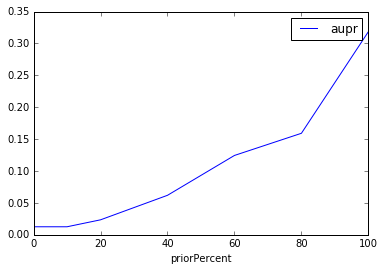

In [9]:
sort.query("method=='PenaltyScaling' and method_x=='InfOnly'").plot(x='priorPercent', y='aupr')

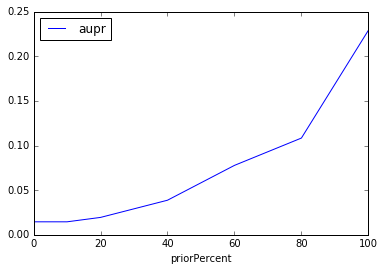

In [10]:
sort.query("method=='FeatureScaling' and method_x=='InfOnly'").plot(x='priorPercent', y='aupr')

/home/doaa/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


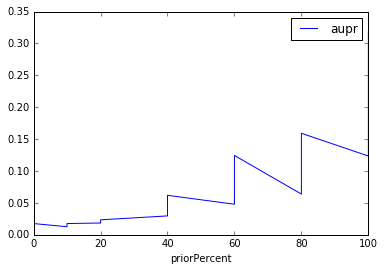

In [21]:
data = sort[['method', 'method_x', 'aupr', 'priorPercent']]
data['method_name'] = data.method + '_' +data.method_x
data = data[['method_name', 'aupr', 'priorPercent']]
data
data.set_index('method_name', inplace=True)
data.plot(x='priorPercent')

In [7]:
r = pd.read_csv('experiments/PK_log_full2.csv')

In [8]:
r['ratio'] = r['NumTrueP'] / r['NumTF'] *100

In [11]:
r['ratio'].argmax()

694

In [17]:
r.query('ratio > 50 and NumTF>1')

GeneName              TFsList  NumTF  NumTrueP  NumFalseP  Predicted  \
1582    G1583         ['G1' 'G98']    2.0       2.0        7.0          0   
3624    G3625  ['G1' 'G98' 'G172']    3.0       2.0        2.0          0   

           ratio  
1582  100.000000  
3624   66.666667